In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from dr_path import settings
from dr_path.db import io, models
from dr_path.loadshape.precalculated_features import hourly_shift_potential
from dr_path.loadshape.utils import create_cal_data
from peewee import fn
%matplotlib inline

In [20]:
region = 'NENG'
db_file = os.path.join(settings.ROOT_DIR, region, 'dr_path_{r}.db'.format(r=region))
print(db_file)
#Close the DB if it's open
try:
    models.database.close()
except:
    pass
models.database.init(db_file)
models.database.connect()
print('Database contains {} demand scenarios.'.format(models.DemandScenario.select().count()))

/mnt/sdb/bgerke_cache/bto_ee_dr_cache/dr_path_inputs_resstock_comstock_2012/NENG/dr_path_NENG.db
Database contains 6 demand scenarios.


In [21]:
tou_name = 'none' #'high'
tech_name = 'BAU'
weather='2012AMY'
ds_name = 'BaseDemand_Baseline_2012AMY'
year=2040
dr_type='shift'
cost_frame = 'gross'

outsubdir = 'all_eligible_upgrades_20210503/{r}'.format(r=settings.REGION)
outdir = '/mnt/sdb/bgerke_cache/bto_ee_dr_cache/reeds_outputs/'+outsubdir


ds = models.DemandScenario.get(name=ds_name)
tou = models.TOUImpactScenario.get(name=tou_name)
rs = models.RenewableScenario.get(id=1)#name='phase2', weather=ds.weather)
ts = models.TechnologyScenario.get(name=tech_name)


In [22]:
y=2030
fulloutdir = os.path.join(outdir,ds.name,str(y))
pd.read_csv(os.path.join(fulloutdir,'shift_capacity.csv'), header=[0,1,2], index_col=0)/1e6

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sdb/bgerke_cache/bto_ee_dr_cache/reeds_outputs/all_eligible_upgrades_20210503/NENG/BaseDemand_Baseline_2012AMY/2030/shift_capacity.csv'

In [23]:
y=2035
fulloutdir = os.path.join(outdir,ds.name,str(y))
pd.read_csv(os.path.join(fulloutdir,'shift_capacity.csv'), header=[0,1,2], index_col=0)/1e6

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sdb/bgerke_cache/bto_ee_dr_cache/reeds_outputs/all_eligible_upgrades_20210503/NENG/BaseDemand_Baseline_2012AMY/2035/shift_capacity.csv'

In [24]:
for y,_ in settings.YEAR_CHOICES:
    ccount = models.ClusterLoadShape.select().join(models.Cluster).where(models.Cluster.year==y).count()
    print('{n} cluster load shapes in year {y}'.format(n=ccount, y=y))

47670 cluster load shapes in year 2020
47670 cluster load shapes in year 2025
47670 cluster load shapes in year 2030
47670 cluster load shapes in year 2035
47670 cluster load shapes in year 2040


In [25]:
dr_type='shift'
features = io.modelselect2dataframe(
    models.CLSFeature.select(
        models.Cluster.name,
        models.Cluster.year,
        models.EndUse.name.alias('end_use'),
        models.CLSFeature.value,
    ).join(models.ClusterLoadShape).join(
        models.EndUse).switch(models.ClusterLoadShape).join(
        models.Cluster).where(
        (models.CLSFeature.dr_type==dr_type) &
        (models.CLSFeature.demand_scenario==ds) &
        (models.CLSFeature.timescale=='year') & 
        (models.CLSFeature.event_hours==4) &
        (models.EndUse.name!='battery')
    )
)
features.head()

name  year         end_use  \
0  CT_Bridgeport-Sikorsky.Mem.AP-Mobile_Home_0  2020   clothes_dryer   
1  CT_Bridgeport-Sikorsky.Mem.AP-Mobile_Home_0  2020  clothes_washer   
2  CT_Bridgeport-Sikorsky.Mem.AP-Mobile_Home_0  2020         cooking   
3  CT_Bridgeport-Sikorsky.Mem.AP-Mobile_Home_0  2020         cooling   
4  CT_Bridgeport-Sikorsky.Mem.AP-Mobile_Home_0  2020      dishwasher   

        value  
0  117.875728  
1    5.640378  
2   51.893856  
3  166.319577  
4   16.024922

In [26]:
features.groupby(['year', ])['value'].sum()

year
2020    4.730092e+07
2025    4.858836e+07
2030    4.954270e+07
2035    5.048670e+07
2040    5.259328e+07
Name: value, dtype: float64

In [27]:
fig,ax = plt.subplots(1,1,figsize=[15,5])
for y,_ in settings.YEAR_CHOICES:
    gls = pd.Series(models.GrossLoadShape.get(demand_scenario=ds, year=y).hourly_kwh)
    ax = gls.loc[100*24:107*24].plot(ax=ax,label=str(y))
ax.legend()

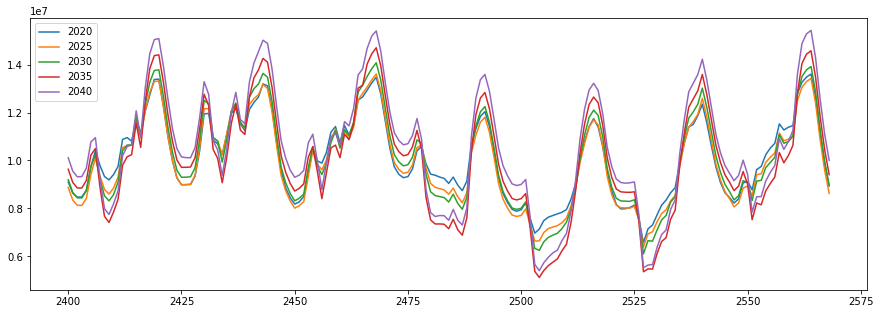

In [28]:
fig,ax = plt.subplots(1,1,figsize=[15,5])
for y,_ in settings.YEAR_CHOICES:
    nls = pd.Series(models.NetLoadShape.get(demand_scenario=ds, year=y).hourly_kwh)
    ax = nls.loc[100*24:107*24].plot(ax=ax,label=str(y))
ax.legend()